<a href="https://colab.research.google.com/github/Lakshman511/EVA4/blob/master/S8/EVA_4_S8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount the drive where we will save stats and loade our libraries from
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [3]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)


[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
import sys
sys.path.append('/content/drive/My Drive/myLibrary')

In [0]:
import numpy as np
import eva4datatransforms as eva4datatransforms
from torchvision import transforms
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
trans = eva4datatransforms.Transforms(normalize=True, mean=channel_means, stdev=channel_stdevs)
fillmeans = (np.array(channel_means)*255).astype(np.uint8)
# Train Phase transformations
train_transforms = trans.train_transforms([
                                       #  transforms.Resize((28, 28)),
                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=tuple(fillmeans)),
                                       transforms.RandomHorizontalFlip(),
                                       ], 
                                       
                                       [transforms.RandomErasing(value = tuple(channel_means))])

# Test Phase transformations
test_transforms = trans.test_transforms()

In [6]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader()

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

torch.Size([128, 3, 32, 32])
torch.Size([128])


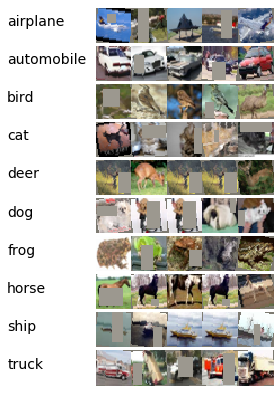

In [8]:
from __future__ import print_function
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))
  #return np.transpose(img, (1, 2, 0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [9]:
import eva4models
import torch
model = eva4models.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = "cuda"
model.to(model.device)
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [10]:
#from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 15
L2lambda = 0
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=L2lambda)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.3, steps_per_epoch=len(train_loader), epochs=EPOCHS)
L1lambda = 0
model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, True, L1lambda)

Validation loss decreased (100000.000000 --> 1.510893).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0113, Accuracy: 47.29%; Test set: Average loss: 1.5109, Accuracy: 49.06%
Learning Rate = 0.045726


Validation loss decreased (1.510893 --> 1.322811).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0085, Accuracy: 61.83%; Test set: Average loss: 1.3228, Accuracy: 58.85%
Learning Rate = 0.131107


Validation loss decreased (1.322811 --> 0.754300).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0068, Accuracy: 69.77%; Test set: Average loss: 0.7543, Accuracy: 74.68%
Learning Rate = 0.228148


Validation loss decreased (0.754300 --> 0.651653).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0058, Accuracy: 74.09%; Test set: Average loss: 0.6517, Accuracy: 77.39%
Learning Rate = 0.291394


Validation loss decreased (0.651653 --> 0.637261).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0051, Accuracy: 77.03%; Test set: Average loss: 0.6373, Accuracy: 78.94%
Learning Rate = 0.298307


Validation loss decreased (0.637261 --> 0.513277).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0045, Accuracy: 79.56%; Test set: Average loss: 0.5133, Accuracy: 83.03%
Learning Rate = 0.285096


Validation loss decreased (0.513277 --> 0.489063).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0041, Accuracy: 81.64%; Test set: Average loss: 0.4891, Accuracy: 84.07%
Learning Rate = 0.259880


Validation loss decreased (0.489063 --> 0.429212).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0037, Accuracy: 83.41%; Test set: Average loss: 0.4292, Accuracy: 85.58%
Learning Rate = 0.224901


Validation loss decreased (0.429212 --> 0.402917).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0034, Accuracy: 84.72%; Test set: Average loss: 0.4029, Accuracy: 86.92%
Learning Rate = 0.183267


Validation loss decreased (0.402917 --> 0.359327).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0031, Accuracy: 86.38%; Test set: Average loss: 0.3593, Accuracy: 87.82%
Learning Rate = 0.138677


Validation loss decreased (0.359327 --> 0.353305).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0028, Accuracy: 87.55%; Test set: Average loss: 0.3533, Accuracy: 88.04%
Learning Rate = 0.095093


Validation loss decreased (0.353305 --> 0.350839).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0025, Accuracy: 88.93%; Test set: Average loss: 0.3508, Accuracy: 88.31%
Learning Rate = 0.056388


Validation loss decreased (0.350839 --> 0.304058).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0021, Accuracy: 90.58%; Test set: Average loss: 0.3041, Accuracy: 90.03%
Learning Rate = 0.026001


Validation loss decreased (0.304058 --> 0.284838).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0018, Accuracy: 92.00%; Test set: Average loss: 0.2848, Accuracy: 91.22%
Learning Rate = 0.006631


Validation loss decreased (0.284838 --> 0.283242).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0016, Accuracy: 92.88%; Test set: Average loss: 0.2832, Accuracy: 91.21%
Learning Rate = 0.000001

